In [18]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('../input/train.csv')
df_predict = pd.read_csv('../input/test.csv')

In [19]:
print(pd.DataFrame(df_train.isnull().sum(), columns=['train NaN']), '\n' * 2,
      pd.DataFrame(df_predict.isnull().sum(), columns=['test NaN']))
df_train.head(3)

             train NaN
PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                177
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             2 

              test NaN
PassengerId         0
Pclass              0
Name                0
Sex                 0
Age                86
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin             327
Embarked            0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [36]:
def process_raw_df(df):        
    df_data = df.drop(['PassengerId', 'Age', 'Ticket', 'Cabin', 'Name'], axis=1)
    
    df_data['HasCabin'] = df['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
    df_data['Embarked'] = df_data['Embarked'].fillna('S')
    df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())
    
    try:
        se_Y = df_data['Survived']
        df_X = df_data.drop(['Survived'], axis=1)
    except KeyError:
        se_Y = None
        df_X = df_data    
    
    df_X = pd.get_dummies(df_X).drop(['Sex_female', 'Embarked_S'], axis=1)
    return df_X, se_Y

In [48]:
df_Xtrain, se_Ytrain = process_raw_df(df_train)
df_Xpredict, _ = process_raw_df(df_predict)

In [61]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

n_leafs = list(range(3,9))
n_trees = []
clfs = [] 
for n_leaf in n_leafs:
    # for each n_leaf, find the best number of trees n_tree
    adb = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_leaf_nodes=n_leaf))
    n_tree_grid = {'n_estimators': list(range(50,1025,25))}
    gcv = GridSearchCV(adb, n_tree_grid, cv=5)
    gcv.fit(df_Xtrain, se_Ytrain)
    # best_params_ is a dict like so {'n_estimators': 75} 
    n_trees.append(gcv.best_params_['n_estimators'])
    clfs.append(gcv.best_estimator_)

In [62]:
# now score the clfs using k-fold or Repeated K-Fold
# use the same set of folds to compare the clfs, or random sets each time
score_means = []
score_stds = []
for n_leaf, n_tree, clf in zip(n_leafs, n_trees, clfs):
    scores = cross_val_score(clf, df_Xtrain, se_Ytrain, cv=5)
    score_means.append(scores.mean())
    score_stds.append(scores.std())

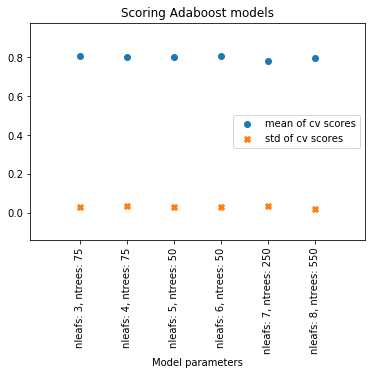

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

x_tickmarks = ['nleafs: {0}, ntrees: {1}'.format(i, j) for i, j in zip(n_leafs, n_trees)]
x = range(len(x_tickmarks))
plt.figure()
plt.scatter(x, score_means, marker='o', label='mean of cv scores')
plt.scatter(x, score_stds, marker='X', label='std of cv scores')
plt.legend(loc='best')
plt.title('Scoring Adaboost models')
plt.xlabel('Model parameters')
plt.xticks(x, x_tickmarks, rotation='vertical')
plt.margins(0.2)

In [65]:
best_adb = clfs[score_means.index(max(score_means))]
predictions = best_adb.predict(df_Xpredict)
df_submit = pd.DataFrame({'PassengerId': df_predict['PassengerId'], 
                          'Survived': predictions})
df_submit.to_csv('submit.csv', index=False)